# Model Training and Testing

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from module.module_analyze_viz import plot_bar
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree


### Loading Dataset

In [12]:
df = pd.read_csv('data/booking_after_encoding.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36280 entries, 0 to 36279
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36280 non-null  object 
 1   number_of_adults          36280 non-null  int64  
 2   number_of_children        36280 non-null  int64  
 3   number_of_weekend_nights  36280 non-null  int64  
 4   number_of_week_nights     36280 non-null  int64  
 5   type_of_meal              36280 non-null  int64  
 6   car_parking_space         36280 non-null  int64  
 7   room_type                 36280 non-null  int64  
 8   lead_time                 36280 non-null  int64  
 9   market_segment_type       36280 non-null  int64  
 10  repeated                  36280 non-null  int64  
 11  P_C                       36280 non-null  int64  
 12  P_not_C                   36280 non-null  int64  
 13  average_price             36280 non-null  float64
 14  specia

In [14]:
df.columns

Index(['Booking_ID', 'number_of_adults', 'number_of_children',
       'number_of_weekend_nights', 'number_of_week_nights', 'type_of_meal',
       'car_parking_space', 'room_type', 'lead_time', 'market_segment_type',
       'repeated', 'P_C', 'P_not_C', 'average_price', 'special_requests',
       'date_of_reservation', 'booking_status', 'reservation_day',
       'reservation_month', 'reservation_year', 'date_of_arrival',
       'arrival_day', 'arrival_month', 'arrival_year', 'lead_month',
       'number_of_total_nights', 'number_of_total_people'],
      dtype='object')

### Normalization

In [15]:
scaler = StandardScaler()
scaler.fit(df.drop(['Booking_ID','date_of_reservation','date_of_arrival','booking_status'], axis=1))
scaled_features = scaler.transform(df.drop(['Booking_ID','date_of_reservation','date_of_arrival','booking_status'],axis=1))
df_normalized= pd.DataFrame(scaled_features,df.drop(['Booking_ID','date_of_reservation','date_of_arrival','booking_status'], axis=1).columns)
df_normalized.head()

number_of_adults  ...  number_of_total_people
0         -1.628897  ...               -1.471726
1          0.298955  ...                1.628443
2         -1.628897  ...               -1.471726
3         -1.628897  ...               -1.471726
4         -1.628897  ...                0.078359

[5 rows x 23 columns]

In [16]:
X = df_normalized
y = df['booking_status']

# FEATURE SELECTION

### Univariate Feauture Selection (Select k best)
- Statistical tests can be used to select those features that have the strongest relationship with the output variable.

- The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

- Many different statistical test scan be used with this selection method. For example the ANOVA F-value method is appropriate for numerical inputs and categorical data, as we see in the these dataset.

In [18]:
def feauture_selection_select_k_best(k, X, y):
    k_best = SelectKBest(k=k, score_func=f_classif)

    k_best.fit_transform(X, y)
    # Get the indices of the selected features
    selected_features_indices = k_best.get_support(indices=True)

    # Get the scores associated with each feature
    feature_scores_k_best = k_best.scores_

    # Create a list of tuples containing feature names and scores
    feature_info = list(zip(X.columns, feature_scores_k_best))

    # Sort the feature info in descending order based on scores
    sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)
    
    feature_names, feature_scores = zip(*sorted_feature_info[:])
    df_feauture_k_best_score = pd.DataFrame({'feature_name':feature_names,'feature_score':feature_scores})
    df_feautures_k_best =df_normalized.iloc[:, selected_features_indices]

    return df_feauture_k_best_score, df_feautures_k_best

In [19]:
df_feauture_k_best_score, df_feautures_k_best = feauture_selection_select_k_best(8,X,y)

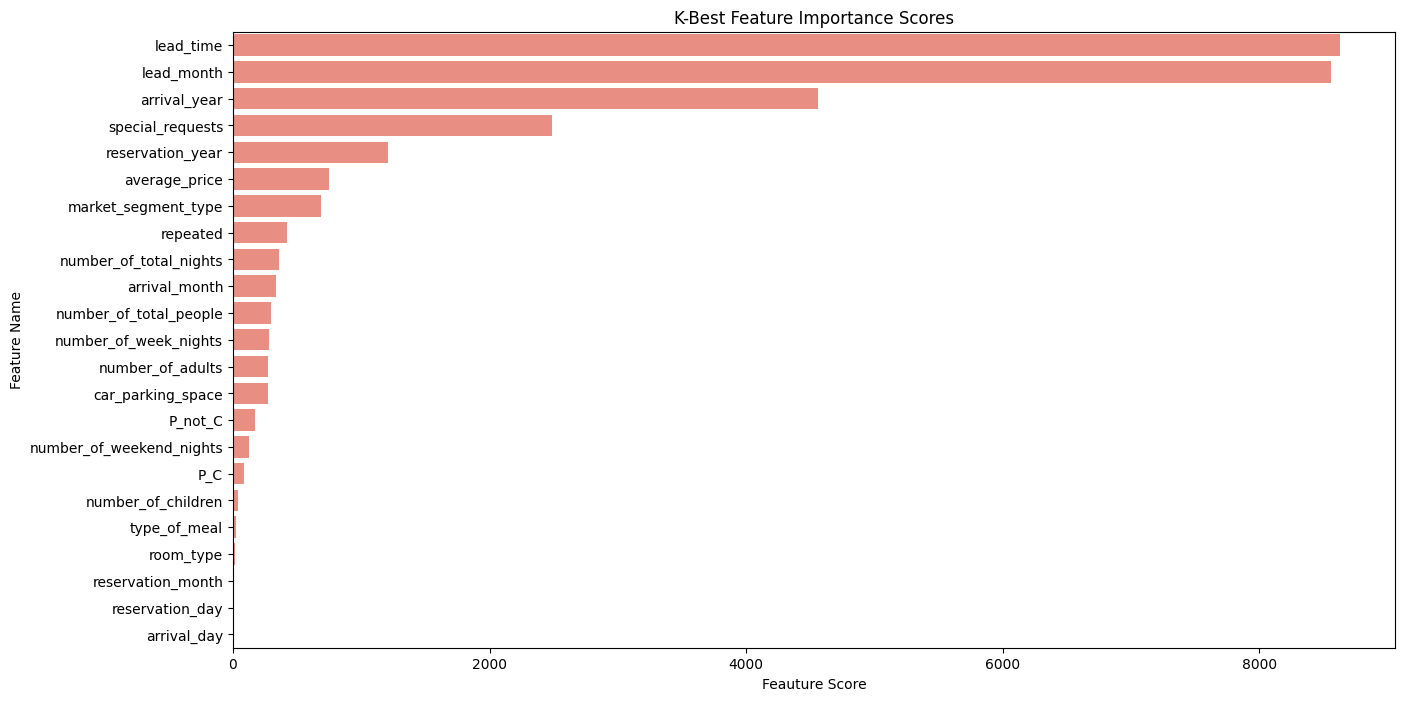

In [20]:
plot_bar(df_feauture_k_best_score,'feature_score', 'feature_name','K-Best Feature Importance Scores', 'Feauture Score', 'Feature Name',color='salmon',orient='h')

In [21]:
df_feautures_k_best.columns

Index(['lead_time', 'market_segment_type', 'repeated', 'average_price',
       'special_requests', 'reservation_year', 'arrival_year', 'lead_month'],
      dtype='object')

### Extra Tree Classifier
Methods that use ensembles of decision trees (like Random Forest or Extra Trees) 
can also compute the relative importance of each attribute.
 These importance values can be used to inform a feature selection process.

In [22]:
def feature_selection_extra_trees_classifier(X,y):
    model = ExtraTreesClassifier()
    model.fit(X, y)
    feature_info = list(zip(X.columns, model.feature_importances_))

    # Sort the feature info in descending order based on scores
    sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)
    feature_names, feature_scores = zip(*sorted_feature_info[:])
    df_extra_tree_class_feature_score = pd.DataFrame({'feature_name':feature_names,'feature_score':feature_scores})
    extra_tree_class_selected_features = df_extra_tree_class_feature_score.query( 'feature_score > 0.05')['feature_name']
    df_feautures_extra_tree_class =df_normalized.loc[:, extra_tree_class_selected_features]
    return df_extra_tree_class_feature_score,df_feautures_extra_tree_class

 

In [23]:
df_extra_tree_class_feature_score,df_feautures_extra_tree_class = feature_selection_extra_trees_classifier(X,y)

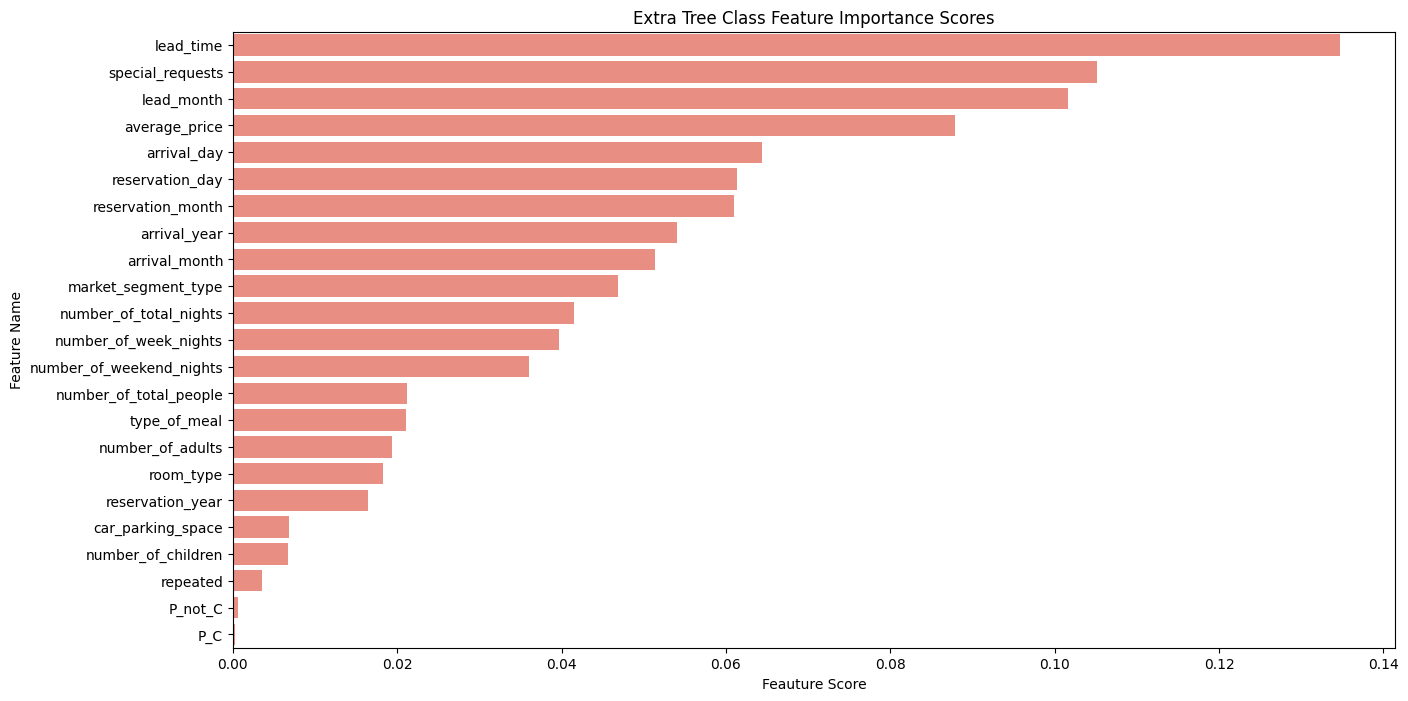

In [24]:
plot_bar(df_extra_tree_class_feature_score,'feature_score', 'feature_name','Extra Tree Class Feature Importance Scores', 'Feauture Score', 'Feature Name',color='salmon',orient='h')

In [25]:
df_feautures_extra_tree_class.columns

Index(['lead_time', 'special_requests', 'lead_month', 'average_price',
       'arrival_day', 'reservation_day', 'reservation_month', 'arrival_year',
       'arrival_month'],
      dtype='object')

### Logistic Regression Feature Selection
We can fit a LogisticRegression model on the regression dataset and retrieve the coeff_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a mode

In [26]:
def feauture_selection_logistic_regression(X,y):
  model = LogisticRegression()
  # fit the model
  model.fit(X, y)
  # get importance
  feature_scores_logistic = model.coef_[0]
  # summarize feature importance
  feature_info = list(zip(X.columns, feature_scores_logistic))
  # Sort the feature info in descending order based on scores
  sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)
  feature_names, feature_scores = zip(*sorted_feature_info[:])
  df_logistic_feature_score = pd.DataFrame({'feature_name':feature_names,'feature_score':feature_scores})
  logistic_regression_selected_features = df_logistic_feature_score.query( 'feature_score > 0.50 | feature_score < -0.50')['feature_name']
  df_feautures_logistic =df_normalized.loc[:, logistic_regression_selected_features]

  return df_logistic_feature_score,df_feautures_logistic

In [27]:
df_logistic_feature_score, df_feautures_logistic = feauture_selection_logistic_regression(X,y)

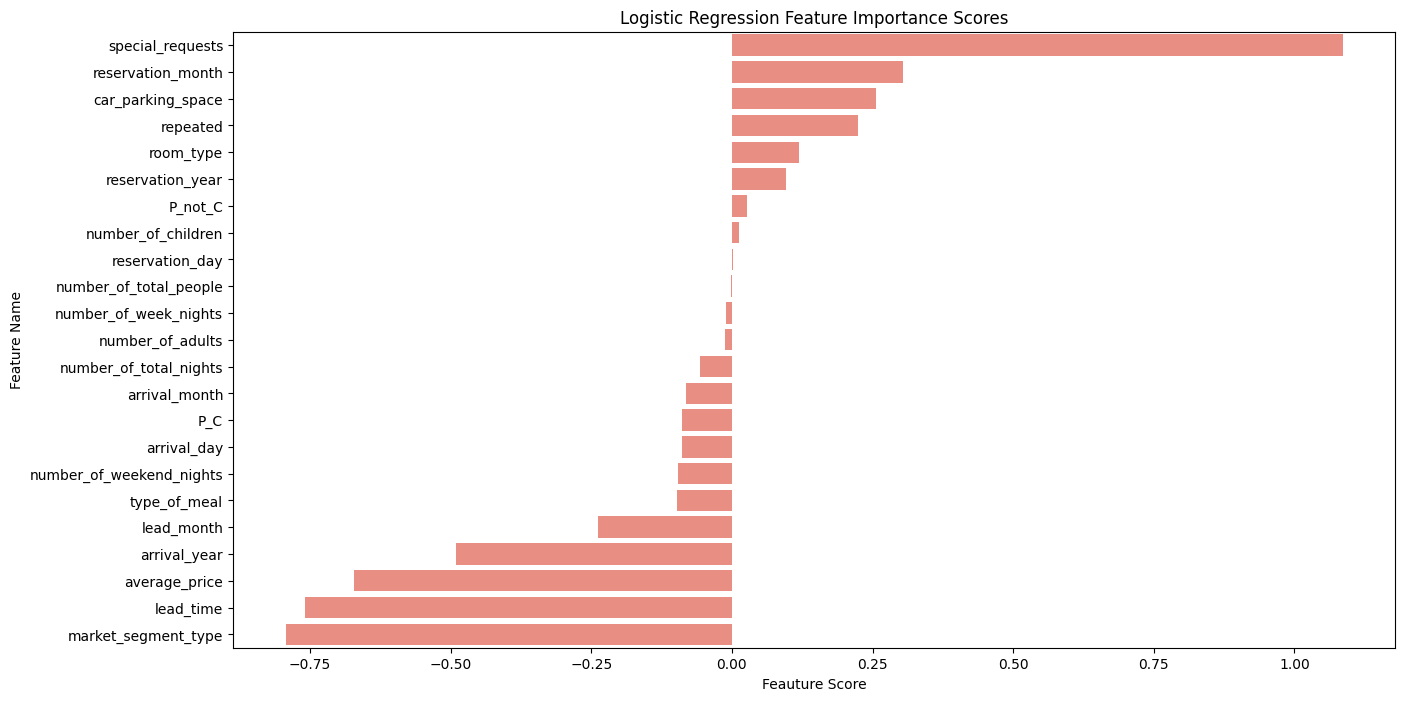

In [28]:
plot_bar(df_logistic_feature_score,'feature_score', 'feature_name','Logistic Regression Feature Importance Scores', 'Feauture Score', 'Feature Name',color='salmon',orient='h')

In [29]:
df_feautures_logistic.head()

special_requests  average_price  lead_time  market_segment_type
0          0.483622       0.097489  -0.933825             0.656666
1         -0.788182      -1.539407  -0.980397             0.656666
2          0.483622      -0.095427   1.464640             0.656666
3         -0.788182      -0.759657  -0.433175             0.656666
4          0.483622       0.122614  -0.596177             0.656666

### Decision Tree Feauture Selection
Similar to logistic regression a model trained with all the data and model's importance score for each variable can determine selected feauturues

In [30]:
# decision tree for feature importance on a 
def feature_selection_dt(X,y):
  model = DecisionTreeClassifier()
  # fit the model
  model.fit(X, y)
  # get importance
  feature_scores_dt = model.feature_importances_
  feature_info = list(zip(X.columns, feature_scores_dt))
  # Sort the feature info in descending order based on scores
  sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)
  feature_names, feature_scores = zip(*sorted_feature_info[:])
  df_dt_feature_score = pd.DataFrame({'feature_name':feature_names,'feature_score':feature_scores})
  dt_selected_features = df_dt_feature_score.query( 'feature_score > 0.05 | feature_score < -0.05')['feature_name']
  df_feautures_dt =df_normalized.loc[:, dt_selected_features]

  return df_dt_feature_score,df_feautures_dt

In [31]:
df_dt_feature_score,df_feautures_dt = feature_selection_dt(X,y)

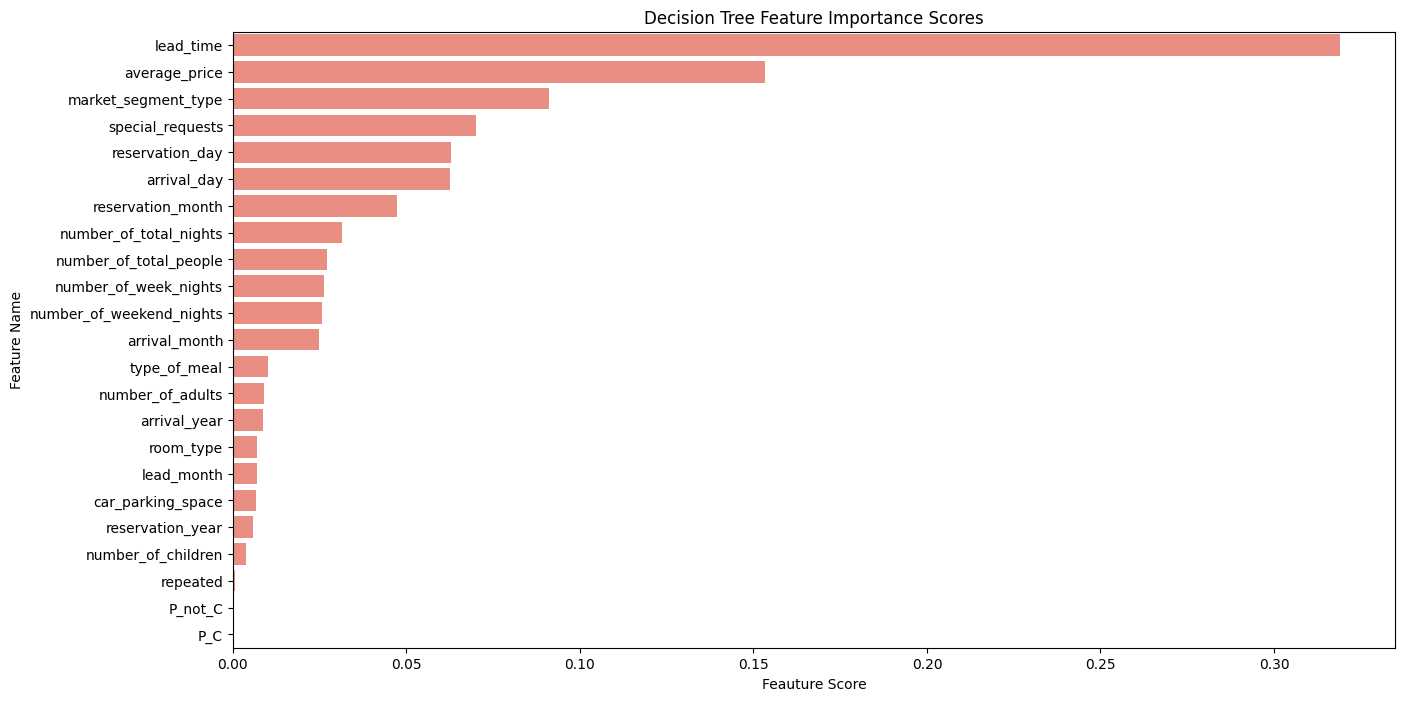

In [32]:
plot_bar(df_dt_feature_score,'feature_score', 'feature_name','Decision Tree Feature Importance Scores', 'Feauture Score', 'Feature Name',color='salmon',orient='h')

In [33]:
df_feautures_dt.head()

lead_time  average_price  ...  reservation_day  arrival_day
0  -0.933825       0.097489  ...        -1.098253    -0.549184
1  -0.980397      -1.539407  ...         1.420551    -1.681093
2   1.464640      -0.095427  ...         0.504622     0.129960
3  -0.433175      -0.759657  ...        -0.525797     1.488250
4  -0.596177       0.122614  ...        -0.067833     0.243151

[5 rows x 6 columns]

In [34]:
def train_model_and_predict(model,X_train,y_train,X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def evaluate_model(model,X_test,y_test, y_pred, display_labels=['Canceled','Not Canceled']):
    titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=display_labels,
            cmap=plt.cm.Greens,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    print(classification_report(y_test,y_pred,labels=[0,1]))

# MODEL TRAINING -EVALUATING

## Logistic Regression

### Training the Model

In [35]:
X_train, X_test, y_train, y_test = train_test_split( df_feautures_logistic, df['booking_status'], test_size=0.2, random_state=10)
logreg = LogisticRegression()
y_pred = train_model_and_predict(logreg,X_train,y_train,X_test)

### Evaluate the Model

Confusion matrix, without normalization
[[1424 1010]
 [ 483 4339]]
Normalized confusion matrix
[[0.58504519 0.41495481]
 [0.10016591 0.89983409]]


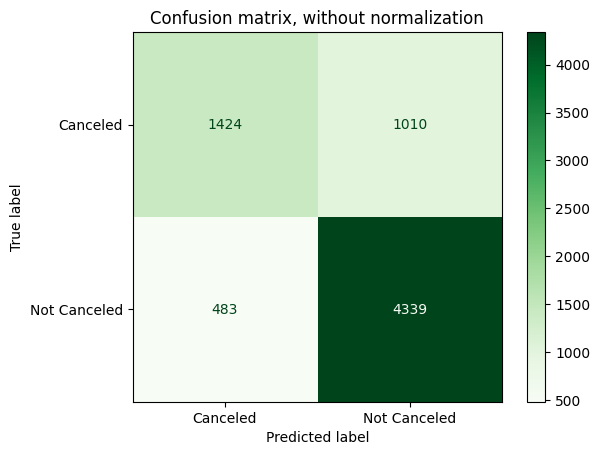

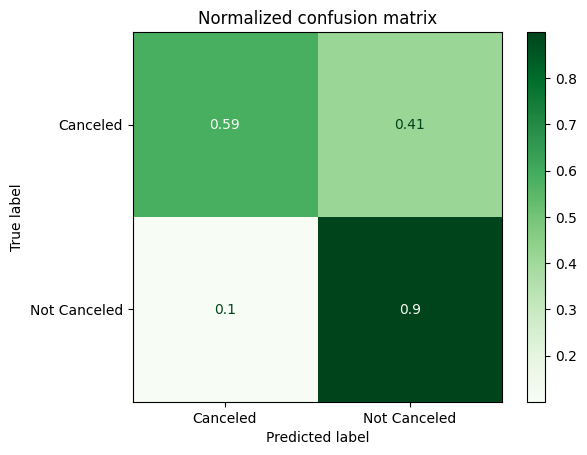

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      2434
           1       0.81      0.90      0.85      4822

    accuracy                           0.79      7256
   macro avg       0.78      0.74      0.75      7256
weighted avg       0.79      0.79      0.79      7256



In [36]:
evaluate_model(logreg,X_test,y_test, y_pred)

## KNN

### Training the Model

In [37]:
X_train, X_test, y_train, y_test = train_test_split( df_feautures_extra_tree_class, df['booking_status'], test_size=0.2, random_state=10)

In [38]:
# Finding the best k
K_MAX= 20

mean_acc = np.zeros((K_MAX-1))
for n in range(1, K_MAX):
    # train and prediction for each k
    classifier = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    pred = classifier.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, pred)


In [39]:
print( "The best accuracy", round(mean_acc.max(),2), "with k=", mean_acc.argmax()+1) 

The best accuracy 0.85 with k= 3


In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
y_pred = train_model_and_predict(knn,X_train,y_train,X_test)

### Evaluate the Model

Confusion matrix, without normalization
[[1797  637]
 [ 469 4353]]
Normalized confusion matrix
[[0.73829088 0.26170912]
 [0.09726255 0.90273745]]


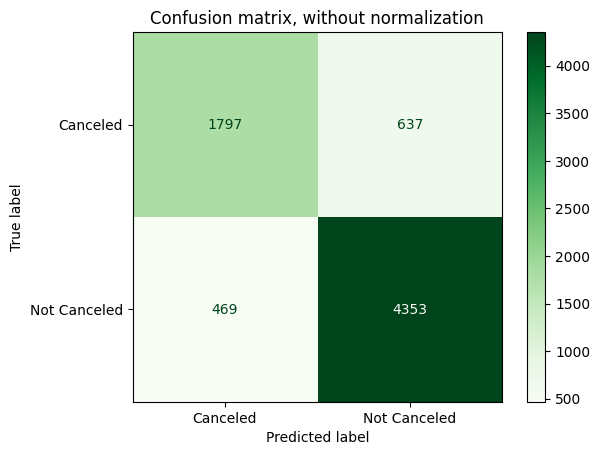

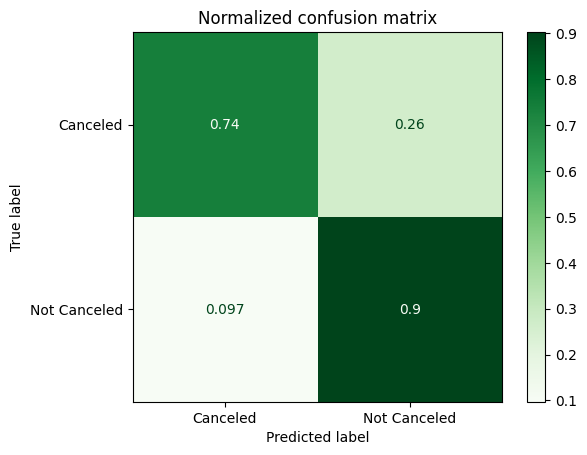

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      2434
           1       0.87      0.90      0.89      4822

    accuracy                           0.85      7256
   macro avg       0.83      0.82      0.83      7256
weighted avg       0.85      0.85      0.85      7256



In [41]:
evaluate_model(knn,X_test,y_test, y_pred)

## Decision Tree

### Training the Model

In [42]:
X_train, X_test, y_train, y_test = train_test_split( df_feautures_dt, df['booking_status'], test_size=0.2, random_state=10)
classifier = DecisionTreeClassifier()
y_pred = train_model_and_predict(classifier,X_train,y_train,X_test)

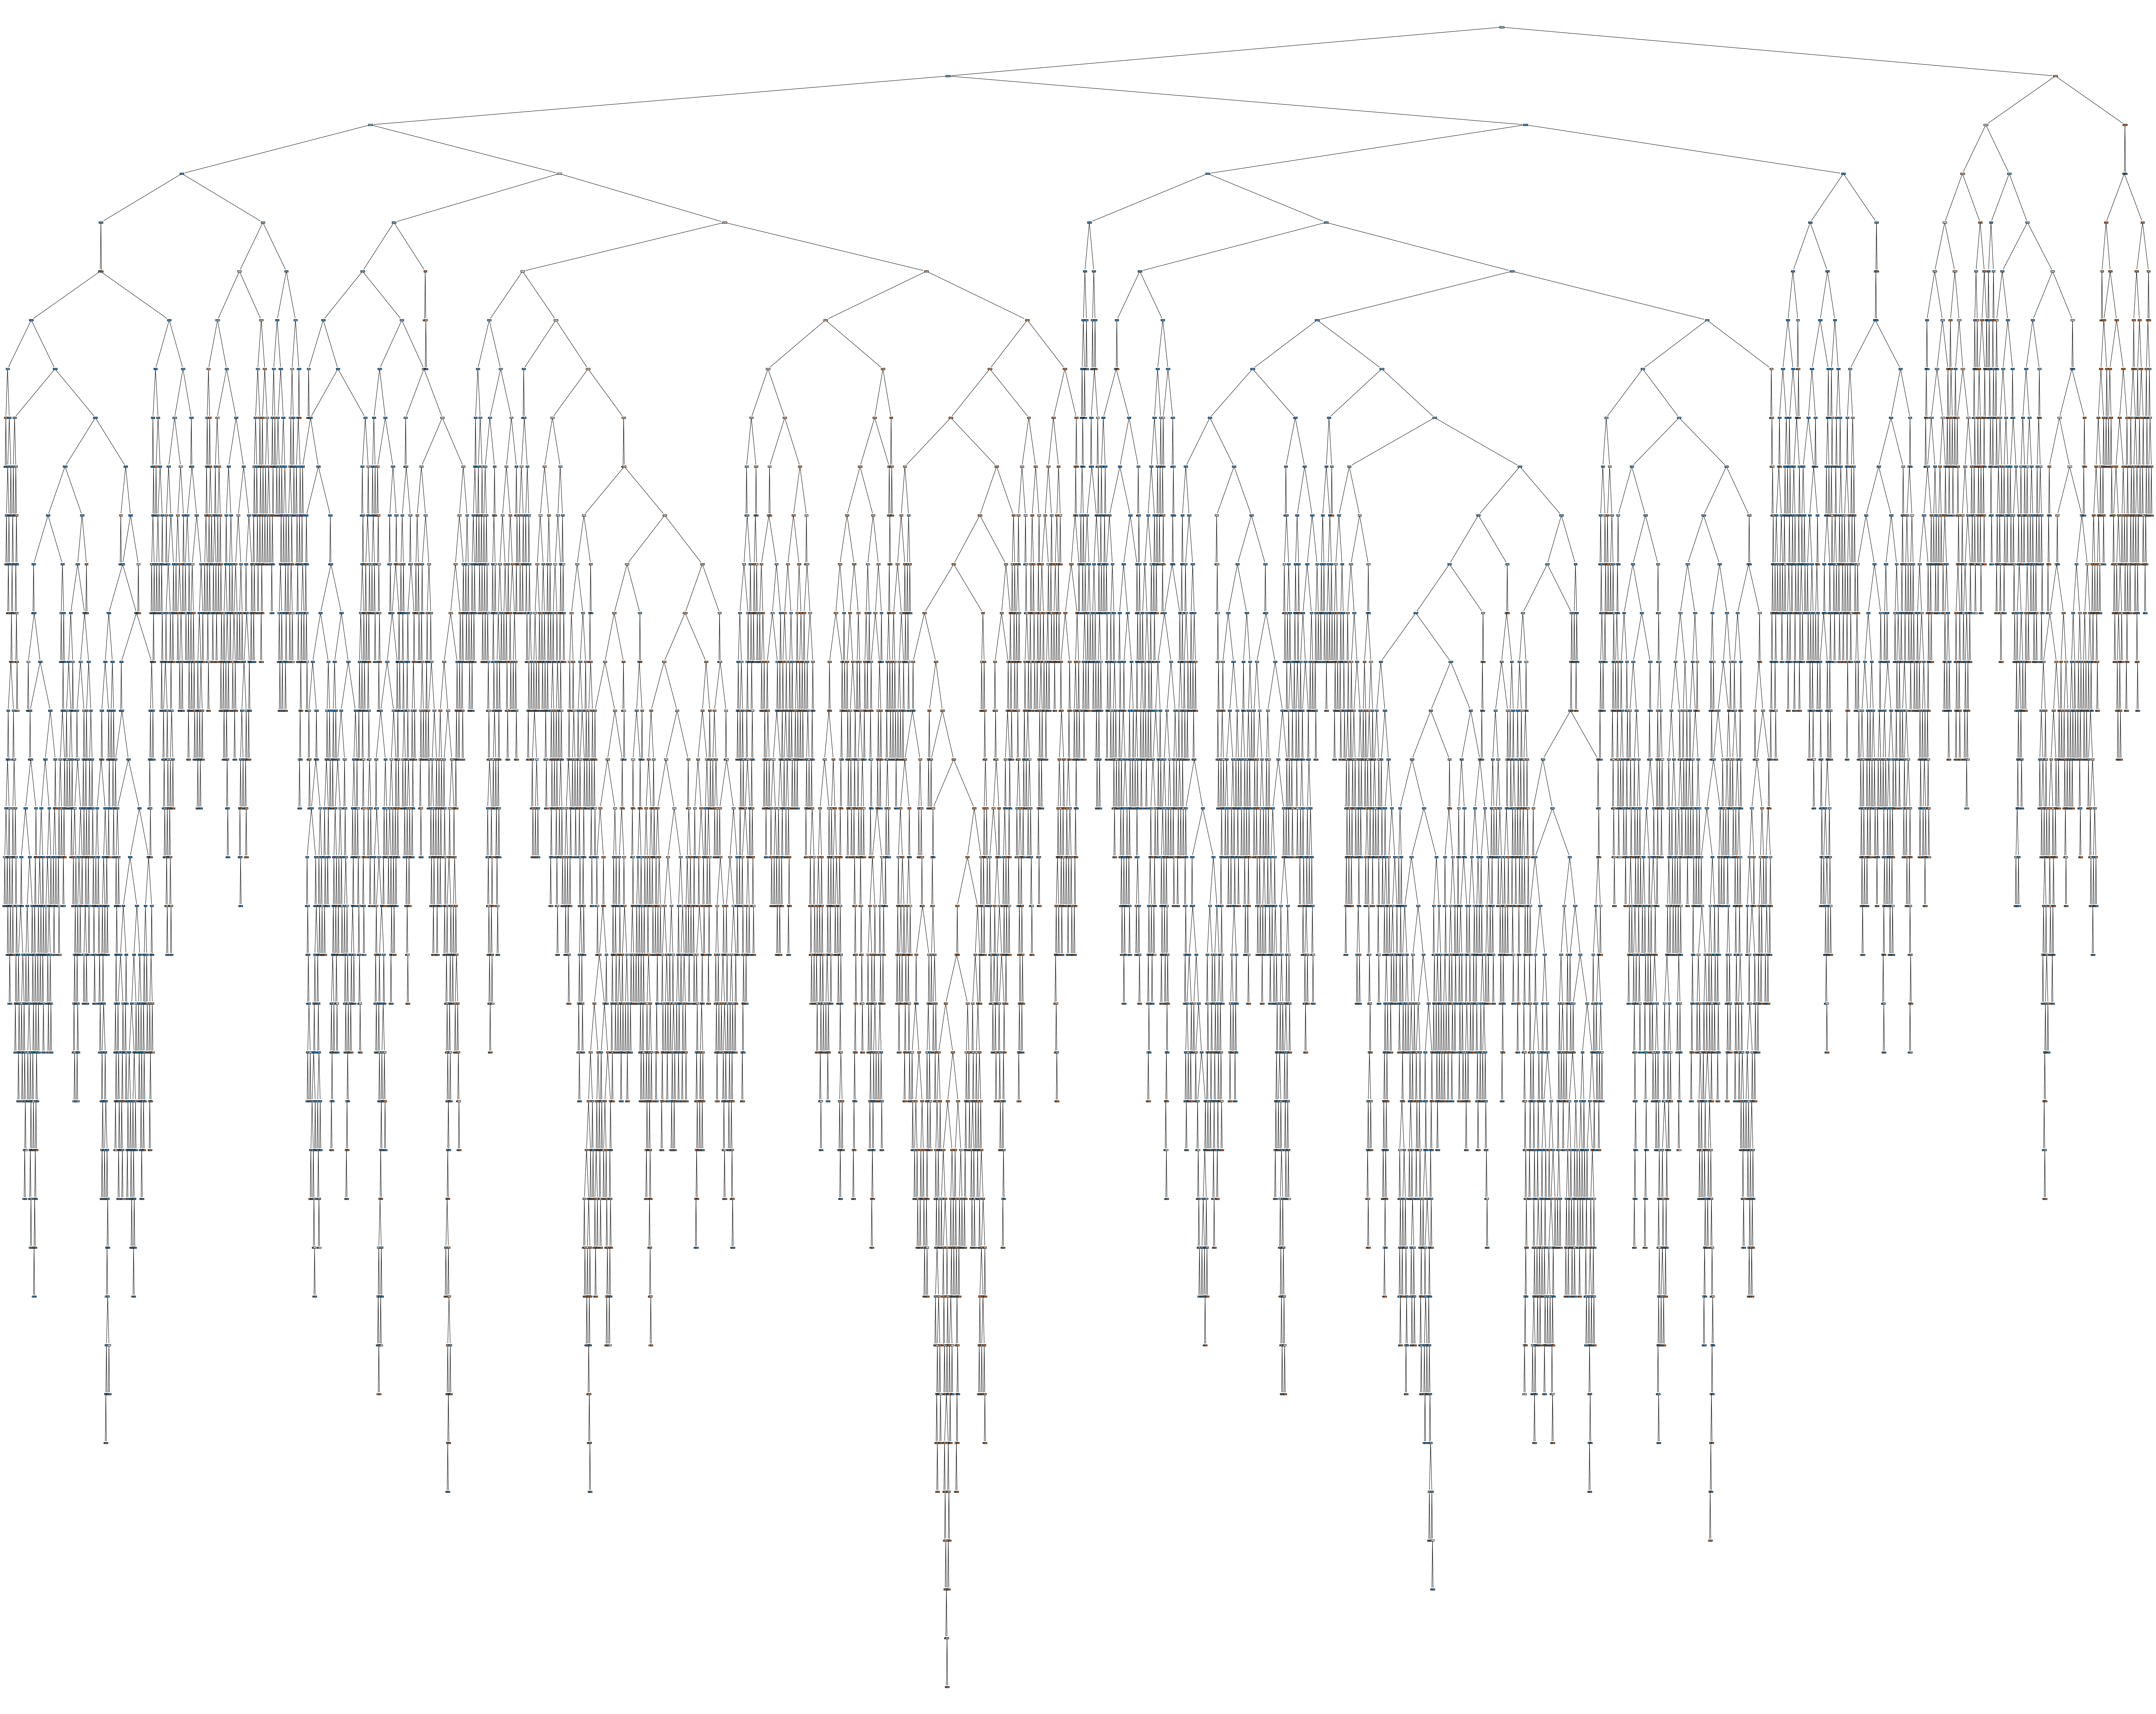

In [49]:
# Decision Tree Plot
fig = plt.figure(figsize=(100,80))
plot_tree(classifier, filled=True)

### Evaluate the Model

Confusion matrix, without normalization
[[1868  566]
 [ 571 4251]]
Normalized confusion matrix
[[0.76746097 0.23253903]
 [0.1184156  0.8815844 ]]


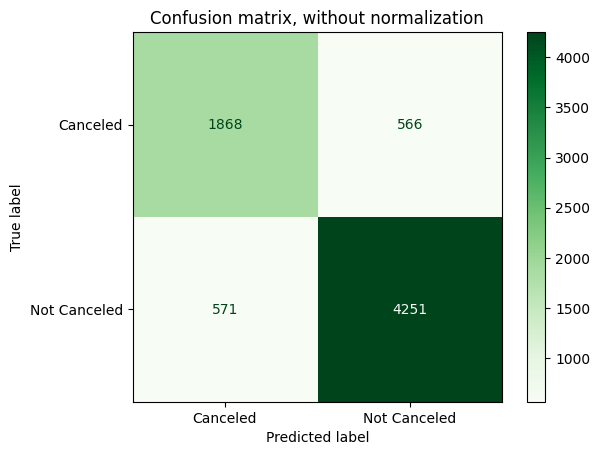

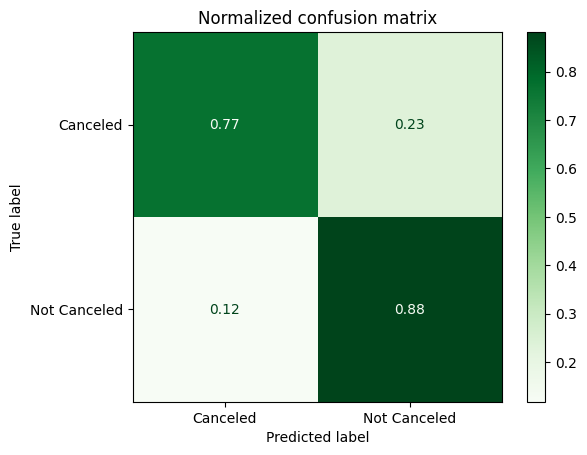

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2434
           1       0.88      0.88      0.88      4822

    accuracy                           0.84      7256
   macro avg       0.82      0.82      0.82      7256
weighted avg       0.84      0.84      0.84      7256



In [35]:
evaluate_model(classifier,X_test,y_test, y_pred)


## SVC

### Training the Model

In [36]:
X_train, X_test, y_train, y_test = train_test_split( df_feautures_extra_tree_class, df['booking_status'], test_size=0.2, random_state=10)

model = svm.SVC(kernel='rbf')
y_pred = train_model_and_predict(model,X_train,y_train,X_test)

model_2 = svm.SVC(kernel='linear')            
y_pred_2 = train_model_and_predict(model_2,X_train,y_train,X_test)


In [37]:

model_3 =model = svm.SVC(kernel='sigmoid')            
y_pred_3 = train_model_and_predict(model_3,X_train,y_train,X_test)

### Evaluate the Model

Confusion matrix, without normalization
[[1195 1239]
 [1130 3692]]
Normalized confusion matrix
[[0.49096138 0.50903862]
 [0.2343426  0.7656574 ]]


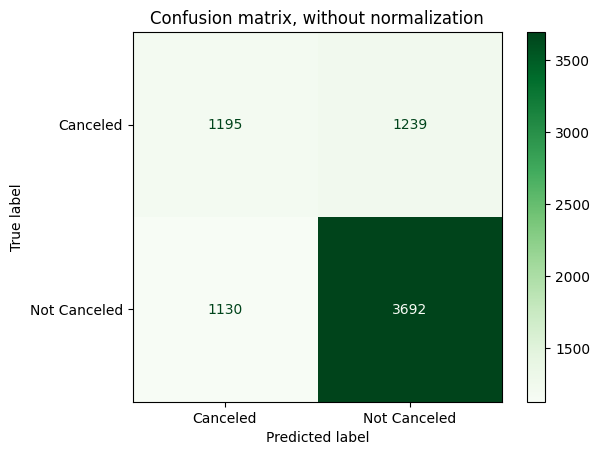

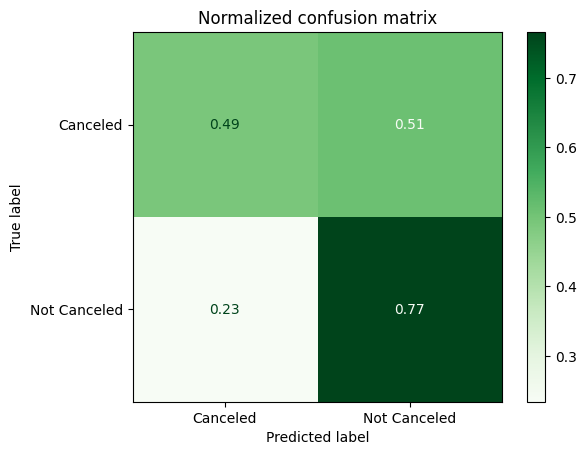

              precision    recall  f1-score   support

           0       0.79      0.59      0.68      2434
           1       0.82      0.92      0.87      4822

    accuracy                           0.81      7256
   macro avg       0.80      0.76      0.77      7256
weighted avg       0.81      0.81      0.80      7256



In [38]:
evaluate_model(model,X_test,y_test, y_pred)

Confusion matrix, without normalization
[[1198 1236]
 [ 411 4411]]
Normalized confusion matrix
[[0.49219392 0.50780608]
 [0.08523434 0.91476566]]


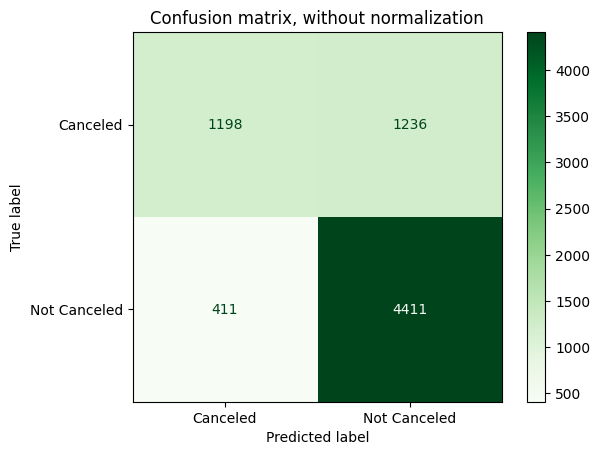

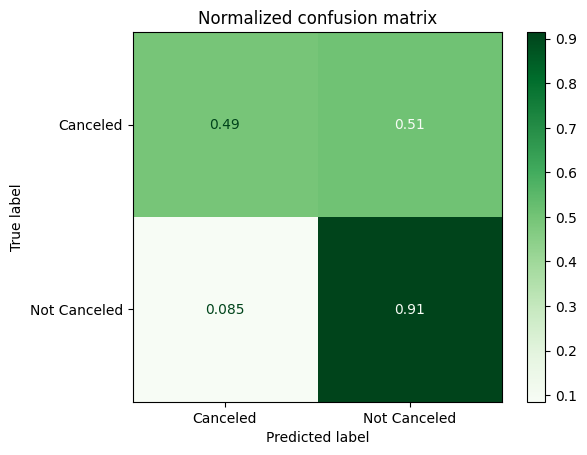

              precision    recall  f1-score   support

           0       0.74      0.49      0.59      2434
           1       0.78      0.91      0.84      4822

    accuracy                           0.77      7256
   macro avg       0.76      0.70      0.72      7256
weighted avg       0.77      0.77      0.76      7256



In [39]:
evaluate_model(model_2,X_test,y_test, y_pred_2)

Confusion matrix, without normalization
[[1195 1239]
 [1130 3692]]
Normalized confusion matrix
[[0.49096138 0.50903862]
 [0.2343426  0.7656574 ]]


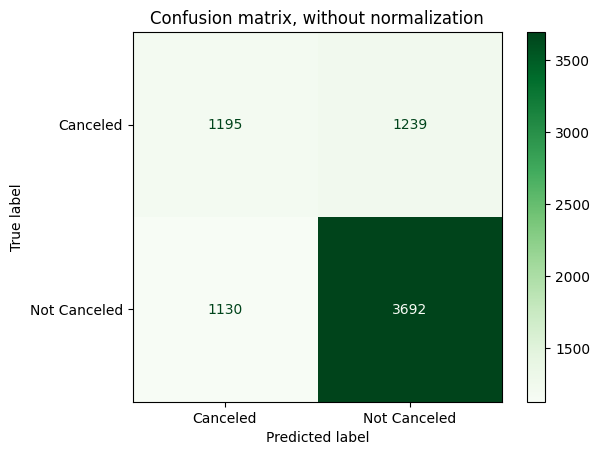

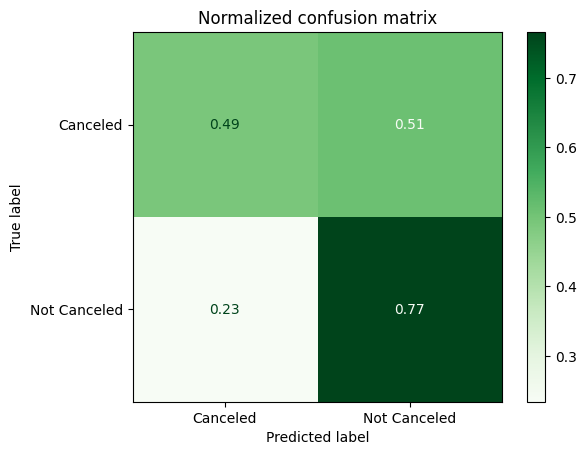

              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2434
           1       0.75      0.77      0.76      4822

    accuracy                           0.67      7256
   macro avg       0.63      0.63      0.63      7256
weighted avg       0.67      0.67      0.67      7256



In [40]:
evaluate_model(model_3,X_test,y_test, y_pred_3)